# Questions



<img src="img/14858512893477_so-logo.png" width="600px">    

<h1 style="font-family:verdana;font-size:300%;text-align:left;">Catégorisez automatiquement des questions</h1>

---
<a id="top"></a>
<h1 style="font-family:verdana;font-size:300%;text-align:left;">Sommaire</h1>

* [1. Process](#1)
* [1. Mise en forme](#1)
    * [2. Import](#2)
    * [2. Bag of words](#2)
    * [3. TF-IDF](#3) 
    
* [2. Approche non supervisée](#2)
    * [3. Word2vec](#3) 
* [3. Approche supervisée](#3)
    * [3. Doc2vec](#3) 

bag of words
Tf idf
doc2vec
BERT avec  librairie DistilBert 


LDA NMF pour réduction dim sur texte

Pour résumer, LDA et NMF transforment ta matrice documents / mots (obtenue avec bag of words ou TF-IDF) en 2 matrices documents / sujets et sujets / mots.  
 Ta matrice initiale aura beaucoup de features (tous tes mots de tous tes textes). Ta matrice documents / sujets aura n features, où n est le nombre de topics (sujets) que tu auras déterminé pour ton algo LDA ou NMF.  
  Tu auras donc fait une réduction de dimension. Les algo de réduction de dimension (PCA, TSNE, etc.) sont non supervisés. Il en va de même pour LDA et NMF.  

Ensuite, tu as plusieurs possibilités. Si tu obtiens des topics interprétables en terme de tags, tu peux assigner le ou les topics en fonction des résultats de la matrice documents / sujets (non supervisé pur).  
 Sinon, tu peux intégrer LDA ou NMF dans un flux supervisé pour réduire les dimensions (on va dire semi-supervisé ou supervisé avec réduction de dimension).  
 Et peut-être que tu auras de meilleurs résultats sans LDA ou NMF (supervisé pur, sans réduction de dimension).


J'ai pas eu trop trop de succès avec les word_embdeddings de type Word2Vec (je me base sur la métrique "v_measure" pour mesurer la correspondance entre mes 7 clusters et les 7 catégories initiales de mes données), donc je me demandais si ça avait des chances de donner de bons résultats.
J'avais utilisé doc2vec , avec plutôt de bons résultats

Bonjour à tous, vous vous y êtes pris comment pour visualiser les résultats de votre LDA et vérifier si elle fonctionnait ?
Intuitivement, en regardant les topics  et si ils avaient du sens. Tu peut aussi calculer un score de cohérence des topic. Puis par la suite, j'ai fait un gridsearch ( avec/sans LDA + modèles) avec différents paramètres pour savoir si ça me donnait de meilleur résultat ou non.
Après, dans mon cas, j'ai abandonné la LDA parce que ça me prenait trop de temps et que les résultats étaient pas terrible. Et j'ai plutôt utilisé NMF (qui immédiatement me donnait de meilleurs résultats).
pyLDAviz

*pour le prétraitement, bag of word ou tf-idf + NMF (optionnel).

tester plusieurs modèles simples (5 ou 7, pas de RF et autres modèles consommateur).
Et ça passais du coup parce que j'utilise que des modèles simples (RF + OVR, c'était même pas la peine d'y penser...).

l était aussi surpris par les résultats de la LDA et de la NMF 
pour évaluer Jaccard

Une régression logistique en OVR 

In [3]:
%matplotlib inline

# Generic librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell

# ML librairies
from gensim import corpora, models, similarities
from sklearn import metrics, decomposition, multiclass


# API, model management
from flask import Flask
import joblib # to save and load the model

# pd.set_option('display.max_column', 100)

# Activate multi output
InteractiveShell.ast_node_interactivity = "all"

# # For jupyter NB users 
# # set size of window
# display(HTML(data="""
# <style>
#     div#notebook-container    { width: 95%; }
#     div#menubar-container     { width: 65%; }
#     div#maintoolbar-container { width: 99%; }
# </style>
# """))

<a id="1"></a>
<h2 style="font-family:verdana;font-size:250%;text-align:left;">1. Process</h2>

---

Nous somme face à un problème de classification multi label.
Nous cherchons pour chaque question à prédire un ou plusieurs tags.

<img src="img/multi label class.png" width="600px">   

Nous allons tout d'abord 

<a id="1"></a>
<h2 style="font-family:verdana;font-size:250%;text-align:left;">1. Import</h2>
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Sommaire</a>

---

Importons notre dataset et placons le dans un pandas dataframe.  
Nous utiliserons les dates comme index.

In [149]:
file = "data/data_clean.csv"
df_raw = pd.read_csv(file, index_col='CreationDate', parse_dates=True)

In [150]:
df_raw.head()
df_raw.shape
df_raw.info()

,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount,Body_tok,Title_tok,Tags_tok,Text_tok,Text
CreationDate,,,,,,,,,,,,,
2010-09-27 06:56:36,152,66955,i lately had the problem of creating add and e...,good or bad practice for dialogs in wpf with m...,<c#><.net><wpf><mvvm><modal-dialog>,3,12,115,"['problem', 'creating', 'add', 'edit', 'wpf', ...","['good', 'bad', 'practice', 'wpf']","['c#', '.net', 'wpf', 'modal', 'dialog']","['good', 'bad', 'practice', 'wpf', 'problem', ...",good or bad practice for dialogs in wpf with m...
2008-08-11 08:55:13,147,253229,"in c, are the shift operators (<<,>>) arithmet...","are the shift operators (<<, >>) arithmetic or...",<c><binary><bit-manipulation><bit-shift>,11,1,60,"['c', 'shift', 'operator', 'logical']","['shift', 'operator', 'logical', 'c']","['c', 'binary', 'bit', 'bit', 'shift']","['shift', 'operator', 'logical', 'c', 'c', 'sh...","are the shift operators (<<, >>) arithmetic or..."
2008-08-11 10:27:22,815,576716,"whenever i design a database, i always wonder ...","database, table and column naming conventions?",<database><database-design><language-agnostic>...,23,4,359,"['whenever', 'design', 'database', 'always', '...","['database', 'table', 'column', 'naming']","['database', 'database', 'design', 'language',...","['database', 'table', 'column', 'naming', 'whe...","database, table and column naming conventions?..."
2008-08-11 11:57:17,110,238131,is this even a valid question? i have a .net w...,how do i enable msdtc on sql server?,<sql-server><msdtc>,6,1,30,"['even', 'valid', 'question', '.net', 'window'...","['enable', 'sql', 'server']","['sql', 'server']","['enable', 'sql', 'server', 'even', 'valid', '...",how do i enable msdtc on sql server? is this e...
2008-08-10 18:41:02,539,197771,"what does the expression ""turing complete"" mea...",what is turing complete?,<theory><turing-machines><turing-complete>,15,1,178,"['expression', 'complete', 'mean', 'give', 'si...",['complete'],"['machine', 'complete']","['complete', 'expression', 'complete', 'mean',...",what is turing complete? what does the express...


(28077, 13)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28077 entries, 2010-09-27 06:56:36 to 2018-04-26 23:29:11
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Score          28077 non-null  int64 
 1   ViewCount      28077 non-null  int64 
 2   Body           28077 non-null  object
 3   Title          28077 non-null  object
 4   Tags           28077 non-null  object
 5   AnswerCount    28077 non-null  int64 
 6   CommentCount   28077 non-null  int64 
 7   FavoriteCount  28077 non-null  int64 
 8   Body_tok       28077 non-null  object
 9   Title_tok      28077 non-null  object
 10  Tags_tok       28077 non-null  object
 11  Text_tok       28077 non-null  object
 12  Text           28077 non-null  object
dtypes: int64(5), object(8)
memory usage: 3.0+ MB


In [151]:
df = df_raw[["Text_tok", "Tags_tok"]].copy()


In [152]:
import ast

# by default list are put in strings by pands, let's convert it to lists
df["Text_tok"] = df["Text_tok"].apply(lambda x: ast.literal_eval(x))
df["Tags_tok"] = df["Tags_tok"].apply(lambda x: ast.literal_eval(x))

<a id="2"></a>
<h2 style="font-family:verdana;font-size:250%;text-align:left;">2. Bag of words</h2>
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Sommaire</a>

---
Nous allons maintenant extraire l'information du texte pour pouvoir le traiter par des modèles de machine learning.

Une représentation bag-of-words classique sera celle dans laquelle on représente chaque document par un vecteur de la taille du vocabulaire  |V|.  
On utilisera la matrice composée de l’ensemble de ces N documents qui forment le corpus comme entrée de nos algorithmes.

In [153]:
# we create a dictionnary of the uniques words of corpus
# each word will have an unique id
dictionary = corpora.Dictionary(df.Text_tok)
print(dictionary)

Dictionary(2193 unique tokens: ['.net', 'add', 'anything', 'app', 'approach']...)


In [154]:
# bag of word (sparse matrix)
# return a list of tuple
# first entry in each tuple corresponds to the ID of the token in the dictionary
# the second corresponds to the count of this token.
bow_corpus = [dictionary.doc2bow(text) for text in df.Text_tok]

<a id="3"></a>
<h2 style="font-family:verdana;font-size:250%;text-align:left;">3. TF-IDF</h2>
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Sommaire</a>

---

The tf-idf model transforms vectors from the bag-of-words representation to a vector space where the frequency counts are weighted according to the relative rarity of each word in the corpus.

La métrique tf-idf (Term-Frequency - Inverse Document Frequency) utilise comme indicateur de similarité l'inverse document frequency qui est l'inverse de la proportion de document qui contient le terme, à l'échelle logarithmique.
Il est appelé logiquement « inverse document frequency » (idf). 

In [155]:
# train the model
model_tfidf = models.TfidfModel(bow_corpus)

# transformation of the corpus
tfidf_corpus = model_tfidf[bow_corpus]

# Word2vec

Dans l'architecture word2vec, les 2 algorithmes utilisés sons “continuous bag of words” (cbow) et “skip-gram” (sg).

Nous allons entrainer un modèle puis tester les similarités entre 2 mots.

In [156]:
# X_train, X_test, y_train, y_test = train_test_split(df["Text_tok"], df['Tags_tok'], test_size=0.3, random_state=42)

In [157]:
model_w2v = models.Word2Vec(sentences=df.Text_tok,
window=5,
min_count=5)

In [158]:
model_w2v.wv.similarity("numpy", "matplotlib")
model_w2v.wv.similarity("python", "sql")

0.66607875

0.12026103

On constate que certains termes sont plus "proches" les uns des autres que d'autres.

In [181]:
model_w2v.wv.most_similar(positive=['python', 'numpy'])

[('panda', 0.6897360682487488),
 ('anaconda', 0.6496447324752808),
 ('matplotlib', 0.6392043828964233),
 ('ipython', 0.6241260170936584),
 ('interpreter', 0.602602481842041),
 ('virtualenv', 0.5650103688240051),
 ('pip', 0.5534748435020447),
 ('psycopg', 0.5315456986427307),
 ('notebook', 0.5261490941047668),
 ('generator', 0.5258957743644714)]

On remarque également que pandas a été lemmatizé en panda.

In [32]:
# metrics.jaccard_score(y_predict, y_test)
# metrics.v_measure_score()

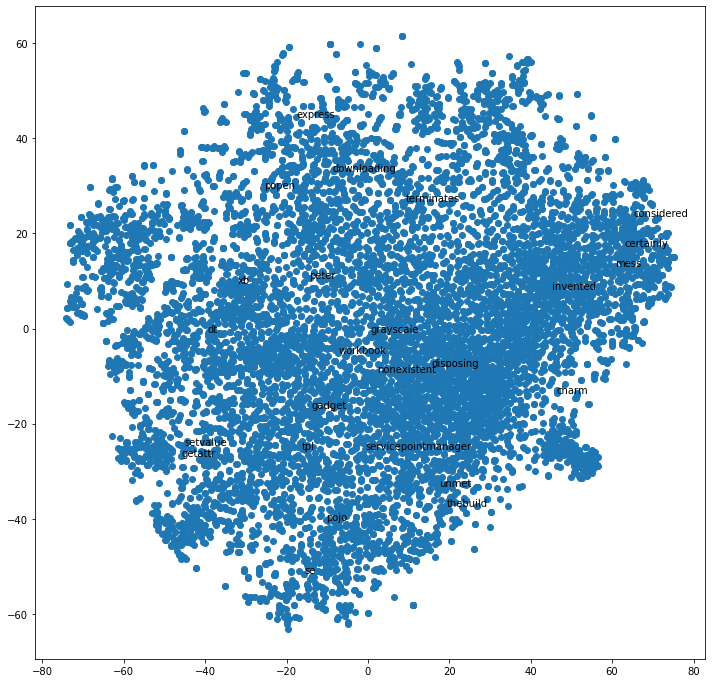

In [37]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model_w2v)

def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

# plot_function(x_vals, y_vals, labels)

plot_with_matplotlib(x_vals, y_vals, labels);

# Doc2Vec

Les algorithmes utilisés dans l'architecture de doc2vec asont “distributed memory” (dm) et “distributed bag of words” (dbow).

Pour ce plongement de mots il est nécessaire d'associé les tags au corpus.

In [98]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df["Text_tok"], df['Tags_tok'], test_size=0.3, random_state=42)

In [99]:
train_corpus = [models.doc2vec.TaggedDocument(doc, i) for doc, i in zip(x_train, y_train)]

In [100]:
test_corpus = x_test.to_list()

In [101]:
model_d2v = models.doc2vec.Doc2Vec(vector_size=50,
min_count=2,
epochs=40)

In [102]:
model_d2v.build_vocab(train_corpus)

In [103]:
# sample
print(f"Word 'android' appeared {model.wv.get_vecattr('android', 'count')} times in the training corpus.")


Word 'android' appeared 11193 times in the training corpus.


In [104]:
model_d2v.train(train_corpus, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)

In [107]:
import random

# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(test_corpus) - 1)
inferred_vector = model_d2v.infer_vector(test_corpus[doc_id])
sims = model_d2v.dv.most_similar([inferred_vector], topn=len(model_d2v.dv))

# Compare and print the most/median/least similar documents from the train corpus
print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(test_corpus[doc_id])))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model_d2v)
for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Test Document (7815): «running code main thread another thread android service created thread background task situation thread need post certain task main thread message queue example way main thread thread»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d50,n5,w5,mc2,s0.001,t3):



TypeError: list indices must be integers or slices, not str

In [120]:

model_d2v.predict_output_word(x_test.to_list()[0])

[('array', 0.031770986),
 ('string', 0.02185764),
 ('convert', 0.011153962),
 ('parameter', 0.008524875),
 ('extract', 0.008425927),
 ('split', 0.0072673755),
 ('concatenate', 0.0061434614),
 ('represent', 0.005943303),
 ('store', 0.005655503),
 ('primitive', 0.00564538)]

In [ ]:
metrics.jaccard_score(y_test.to_list(), y_pred, average="macro")

In [94]:
y_pred = [0, 2, 1, 2]
y_true = [0, 1, 2, 2]
metrics.jaccard_score(y_true, y_pred, average="macro")

0.4444444444444444

In [ ]:
metrics.jaccard_score()

<a id="2"></a>
<h2 style="font-family:verdana;font-size:250%;text-align:left;">2. Approche non supervisée</h2>
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Sommaire</a>

---

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer(lowercase=False)
# X = vectorizer.fit_transform(df['Text_tok'])

# # vectorizer.get_feature_names()
# pd.DataFrame(X.todense(), columns=vectorizer.vocabulary_)

Split

In [ ]:
from sklearn.model_selection import train_test_split

In [122]:
X_train, X_test = train_test_split(tfidf_corpus, test_size=0.3, random_state=42)

In [125]:
X_train[0]

[(150, 0.3322131358755955),
 (151, 0.05139600536839478),
 (351, 0.1244129046964593),
 (520, 0.24125309172577994),
 (540, 0.28438359519659634),
 (602, 0.287369218260629),
 (812, 0.17732500193729694),
 (1631, 0.27418939743385273),
 (1750, 0.3903669575512343),
 (2724, 0.32433337210227486),
 (2771, 0.2467004115501485),
 (3979, 0.28687534942401577),
 (4326, 0.377485260759338)]

# Extraction de topics 

In [124]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 20

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=42)

# Fitter sur les données
lda.fit(X_train)

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



ValueError: Expected 2D array, got 1D array instead:
array=[list([(150, 0.3322131358755955), (151, 0.05139600536839478), (351, 0.1244129046964593), (520, 0.24125309172577994), (540, 0.28438359519659634), (602, 0.287369218260629), (812, 0.17732500193729694), (1631, 0.27418939743385273), (1750, 0.3903669575512343), (2724, 0.32433337210227486), (2771, 0.2467004115501485), (3979, 0.28687534942401577), (4326, 0.377485260759338)])
 list([(17, 0.03909160611151621), (55, 0.06493151952418655), (69, 0.08735425869803409), (77, 0.114705727495067), (85, 0.2711412944428116), (97, 0.25635256271190493), (109, 0.0362942294102181), (129, 0.10947975771680851), (151, 0.035138760705018486), (197, 0.08877124461263557), (221, 0.15492026084292604), (251, 0.055754199444620414), (305, 0.07848962784220435), (308, 0.09425491906096793), (447, 0.13513944346984197), (514, 0.10055933921670727), (515, 0.07582051768425335), (691, 0.14996926092883295), (712, 0.0712252567054992), (726, 0.05860184621917342), (1089, 0.11013144559981938), (1167, 0.11658187442507423), (1215, 0.11854379051618141), (1271, 0.331495748746007), (1364, 0.05467634235173811), (1497, 0.09190672832882196), (1585, 0.10790141324573109), (1718, 0.0837823710988855), (2298, 0.36755143219134495), (2728, 0.5210485710995432), (3318, 0.1199068988260387), (3537, 0.2672604348153195), (4797, 0.17996612032523485)])
 list([(94, 0.12975476139301298), (344, 0.32427398802888324), (551, 0.4655976603187589), (818, 0.37746670754288014), (1607, 0.688771290328538), (1718, 0.21057515429243392)])
 ...
 list([(55, 0.047095402407418156), (62, 0.19411801476046128), (124, 0.06358809615689215), (137, 0.19251770676305288), (151, 0.0509729046117391), (305, 0.11385843532154473), (308, 0.06836392209181899), (348, 0.11907822063693074), (352, 0.14064476490568698), (361, 0.11839583430345853), (363, 0.06141000145997286), (398, 0.10276723160342442), (407, 0.11124107600528654), (448, 0.05088347792450312), (561, 0.17987005694348598), (614, 0.1910826275922963), (627, 0.1651034293019431), (653, 0.15039811657558308), (684, 0.15510124122747523), (685, 0.1312882053221424), (714, 0.12160997180762971), (726, 0.08500886933599554), (735, 0.13095216804606802), (818, 0.21785980665746063), (843, 0.1209874911228631), (1084, 0.14638141226680998), (1342, 0.5663736365835831), (2233, 0.13852323830485952), (2438, 0.22064665242449708), (2828, 0.20409994099938264), (3343, 0.17537401326463664), (3912, 0.20482532045318957), (3978, 0.18903730751380055)])
 list([(67, 0.04750374458691551), (90, 0.019712012328954746), (105, 0.024816197590849447), (129, 0.03743079179410162), (163, 0.03367695304513921), (217, 0.039894812211066694), (338, 0.0696692009001155), (340, 0.03276036364477572), (495, 0.08979255823356244), (512, 0.15901846290841531), (515, 0.025922801350194837), (537, 0.025063982205302305), (603, 0.04648971950729342), (639, 0.023777381361148747), (661, 0.057163339521426805), (682, 0.026682093434523182), (793, 0.09977168722372136), (948, 0.0566883300646453), (1032, 0.03865729322295936), (1073, 0.05550949323586701), (1121, 0.038798585210928674), (1328, 0.021928156846906237), (1358, 0.03240242530223284), (1393, 0.06401445061582198), (1406, 0.09637898162375938), (1498, 0.0446103671580174), (1523, 0.02768458504221352), (1753, 0.04677467824936805), (1957, 0.040255099453874496), (2090, 0.04478076424195099), (2173, 0.11580427180453459), (2367, 0.04417191358297207), (2540, 0.10789044058309898), (2875, 0.0838584631005846), (2986, 0.039542355907785695), (3145, 0.038035840098618996), (3163, 0.04417191358297207), (3187, 0.2271816525681916), (3463, 0.1375450784102583), (3972, 0.04568775954112934), (4026, 0.058481015008504424), (4769, 0.053616411651959774), (4815, 0.29341340614781086), (5749, 0.053616411651959774), (7047, 0.23881694728061936), (7810, 0.11003022232834851), (7871, 0.13125847715355138), (8127, 0.14759384473215256), (8690, 0.06333612589250051), (8867, 0.20933803541150595), (8915, 0.734664137853693)])
 list([(2, 0.04982655030778282), (18, 0.05270148743937395), (55, 0.025796782320089584), (57, 0.0432692677443717), (79, 0.04490942658307732), (93, 0.054235609498602746), (94, 0.041021240659518836), (101, 0.06088740392694047), (109, 0.02883882411598373), (118, 0.07935749794391098), (184, 0.22785768739870046), (189, 0.026517433342242422), (221, 0.041032401266463646), (233, 0.05660669065881074), (251, 0.044301410379530184), (276, 0.14119101558913866), (348, 0.06522579232385212), (363, 0.13455075094037405), (391, 0.06401810185941544), (406, 0.13258300426530326), (426, 0.10461317240053929), (454, 0.06423229131800437), (560, 0.3768375255931884), (638, 0.09934845057047895), (653, 0.1647628972819077), (657, 0.08727838370021516), (783, 0.06333751767885146), (801, 0.10278212512142872), (803, 0.09527613677792109), (872, 0.10354629163421747), (944, 0.058980201952666164), (1072, 0.06823474937439052), (1112, 0.10053967755629775), (1118, 0.08202669135946963), (1328, 0.0509620524889307), (1358, 0.07530473767356427), (1489, 0.0749630174758776), (1630, 0.06762943090722816), (1838, 0.11219426812969008), (2070, 0.08780043686128398), (2241, 0.09010360017053885), (2832, 0.4433481849524941), (2937, 0.09301253381331452), (3056, 0.27700950875081454), (3194, 0.09182615867263873), (3391, 0.12247649801875485), (4063, 0.2515291759304303), (4440, 0.12830411036307973), (5851, 0.210620584686623), (6014, 0.14968256702570726), (6601, 0.1352611897456196), (8852, 0.2705223794912392)])].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Multilabel 

In [159]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.multiclass import OneVsRestClassifier

In [160]:
y = df['Tags_tok']
y

CreationDate
2010-09-27 06:56:36                    [c#, .net, wpf, modal, dialog]
2008-08-11 08:55:13                      [c, binary, bit, bit, shift]
2008-08-11 10:27:22    [database, database, design, language, naming]
2008-08-11 11:57:17                                     [sql, server]
2008-08-10 18:41:02                               [machine, complete]
                                            ...                      
2017-01-29 10:58:46                           [python, progress, bar]
2017-01-30 03:16:39                                                []
2017-01-30 03:56:48                              [java, json, kotlin]
2017-01-30 14:47:03                                                []
2018-04-26 23:29:11                                [virtual, machine]
Name: Tags_tok, Length: 28077, dtype: object

In [161]:
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(y)
y

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [162]:
pd.DataFrame(y, columns=multilabel.classes_)

,.net,absolute,abstract,access,account,aceoledb,action,actionbar,actionsheetpicker,active,...,xhtml,xliff,xml,yarnpkg,year,yield,youtube,zero,zip,zurb
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28073,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28074,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28075,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Metrics for Multi-label classification


**Multi-label classification** problems must be assessed using different performance measures than single-label classification problems. Two of the most common performance metrics are hamming loss and Jaccard similarity.

**Hamming loss** is the average fraction of incorrect labels. Note that hamming loss is a loss function and that the perfect score is 0.

where TP + TN + FP + FN =L(the total number of labels).

**Jaccard similarity** or the Jaccard index, is the size of the intersection of the predicted labels and the true labels divided by the size of the union of the predicted and true labels. It ranges from 0 to 1, and 1 is the perfect score.


In [163]:
# we already have tokens so we want to pass this list to tfidf
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)

In [164]:
X = tfidf.fit_transform(df['Text_tok'])
X.shape, y.shape

((28077, 2193), (28077, 1651))

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [166]:
sgd = SGDClassifier()
lr = LogisticRegression(solver='lbfgs')
svc = LinearSVC()

In [167]:
def j_score(y_true, y_pred):
  jaccard = np.minimum(y_true, y_pred).sum(axis = 1)/np.maximum(y_true, y_pred).sum(axis = 1)
  return jaccard.mean()*100


def print_score(y_pred, clf):
  print("Clf: ", clf.__class__.__name__)
  print('Jacard score: {}'.format(j_score(y_test, y_pred)))
  print('----')

In [176]:
X_train

<19653x2193 sparse matrix of type '<class 'numpy.float64'>'
	with 599634 stored elements in Compressed Sparse Row format>

In [168]:
for classifier in [LinearSVC(C=1.5, penalty = 'l1', dual=False)]:
  clf = OneVsRestClassifier(classifier)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print_score(y_pred, classifier)

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 5 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 20 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 29 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 39 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 48 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 83 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 87 is present

OneVsRestClassifier(estimator=LinearSVC(C=1.5, dual=False, penalty='l1'))

Clf:  LinearSVC
Jacard score: nan
----


<ipython-input-167-e445630cd865>:2: RuntimeWarning:

invalid value encountered in true_divide



In [169]:
for classifier in [sgd, lr, svc]:
  clf = OneVsRestClassifier(classifier)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print_score(y_pred, classifier)

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 5 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 20 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 29 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 39 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 48 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 83 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 87 is present

OneVsRestClassifier(estimator=SGDClassifier())

Clf:  SGDClassifier


<ipython-input-167-e445630cd865>:2: RuntimeWarning:

invalid value encountered in true_divide



Jacard score: nan
----


C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 5 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 20 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 29 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 39 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 48 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 83 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 87 is present

OneVsRestClassifier(estimator=LogisticRegression())

Clf:  LogisticRegression


<ipython-input-167-e445630cd865>:2: RuntimeWarning:

invalid value encountered in true_divide



Jacard score: nan
----


C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 5 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 20 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 29 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 39 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 48 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 83 is present in all training examples.

C:\Users\Admin\miniconda3\envs\env_p5\lib\site-packages\sklearn\multiclass.py:80: UserWarning:

Label not 87 is present

OneVsRestClassifier(estimator=LinearSVC())

Clf:  LinearSVC
Jacard score: nan
----


<ipython-input-167-e445630cd865>:2: RuntimeWarning:

invalid value encountered in true_divide



In [173]:
x = [ 'how to write ml code in python and java i have data but do not know how to do it']

In [174]:
xt = tfidf.transform(x)
clf.predict(xt)

array([[0, 0, 0, ..., 0, 0, 0]])

In [175]:
multilabel.inverse_transform(clf.predict(xt))


[()]

In [ ]:
# joblib.dump(my_model, "my_model.pkl")
# # and later...
# my_model_loaded = joblib.load("my_model.pkl")

In [ ]:
from flask import Flask
from app.src.main import Predict

app = Flask(_name_)


@app.route('/')
def hello():
    return 'Hello, World!'


@app.route('/predict/<path:path_X_test>')
def predict(path_X_test):
    """
    Example: 
    path_X_test=app/data/dataset_single.csv
    Link: 
        http://127.0.0.1:5000/predict/app/data/dataset_single.csv
    """
    isinstance(path_X_test, str)
    y_pred = Predict(path_X_test)
    return {'status': 'OK', 'y_pred': y_pred.tolist()}


if _name_ == '_main_':
    app.run('0.0.0.0', 5000)


postman pour tester les API


ModuleNotFoundError: No module named 'app.src'; 'app' is not a package